In [1]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from loss import GeneratorLoss
from model import Generator, Discriminator
import gc

In [1]:
kl1 = [1,2,3,4,5]
kl1[:2]

[1, 2]

In [2]:
CROP_SIZE = 12
UPSCALE_FACTOR = 4
NUM_EPOCHS = 10
identity = 'vgg_with_loss'

In [3]:
train_datalocation = os.path.join('C:', os.sep, 'data_science_tasks', 'notebooks','masters','code1','SRforOCR','RELEASE_2015-08-31','DATA','TRAIN','HD')
val_datalocation = os.path.join('C:', os.sep, 'data_science_tasks', 'notebooks','masters','code1','SRforOCR','RELEASE_2015-08-31','DATA','VAL','HD')
train_set = TrainDatasetFromFolder(train_datalocation, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(val_datalocation, upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=1, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=1, batch_size=1, shuffle=False)

C:\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [4]:
netG = Generator(UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

# generator parameters: 734219
# discriminator parameters: 5215425


In [5]:
for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        # print(data.size())
        g_update_first = True
        #batch_size = data.size(0)
        batch_size = 50
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        
        optimizerD.step()
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_images = []
        index = 1
        for val_lr, val_hr_restore, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size
            lr = val_lr
            # recursive padding
            for i in range(10):
                lr = torch.nn.functional.pad(lr, (1, 1, 1, 1), 'constant', 0)
                c, w, h = lr[0].size()
                for channel in range(c):
                    for j in range(w):
                        temp = lr[0, channel, max(1, j-2):min(j+3, w-2), 1:3]
                        
                        temp.contiguous().view(1, -1)
                        # print(temp)
                        lr[0, channel, j, 0] = torch.mean(temp)
                        
                        temp = lr[0, channel, max(1, j-2):min(j+3, w-2), h-4:h-2]
                        temp.contiguous().view(1, -1)
                        lr[0, channel, j, h-1] = torch.mean(temp)
                    for k in range(h):
                        temp = lr[0, channel, 1:3, max(1, k-2):min(k+3, h-2)]
                        temp.contiguous().view(1, -1)
                        lr[0, channel, 0, k] = torch.mean(temp)

                        temp = lr[0, channel, w-4:w-2, max(1, k-2):min(k+3, h-2)]
                        temp.contiguous().view(1, -1)
                        lr[0, channel, w-1, k] = torch.mean(temp)
                        



            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)

            sr = sr[:, :, :, 40:]
            sr = sr[:, :, :, :-40]
            sr = sr[:, :, 40:, :]
            sr = sr[:, :, :-40, :]
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = pytorch_ssim.ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10(1 / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            val_bar.set_description(
                desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                    valing_results['psnr'], valing_results['ssim']))
            gc.collect()
            image1 = utils.make_grid(display_transform()(val_hr_restore.squeeze(0)), nrow=3, padding=5)
            # image1.ï¼Œ
            # print(image1.size())
            utils.save_image(image1, out_path + 'epoch_%d_index_%d_%s_hr_restore.png' % (epoch, index , identity), padding=5)

            image2 = utils.make_grid(display_transform()(hr.data.cpu().squeeze(0)), nrow=3, padding=5)
            # print(image2.size())
            utils.save_image(image2, out_path + 'epoch_%d_index_%d_%s_hr.png' % (epoch, index , identity), padding=5)

            image3 = utils.make_grid(display_transform()(sr.data.cpu().squeeze(0)), nrow=3, padding=5)
            
            utils.save_image(image3, out_path + 'epoch_%d_index_%d_%s_sr.png' % (epoch, index, identity), padding=5)
            index += 1

    
            # val_images.extend(
            #     [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
            #      display_transform()(sr.data.cpu().squeeze(0))])

        
        # val_images = torch.stack(val_images)
        # val_images = torch.chunk(val_images, val_images.size(0) // 3)
        # val_save_bar = tqdm(val_images, desc='[saving training results]')
        # index = 1
        # for image in val_save_bar:
        #     image = utils.make_grid(image, nrow=3, padding=5)
        #     utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
        #     index += 1

    # save model parameters
    
    torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d_%s.pth' % (UPSCALE_FACTOR, epoch, identity))
    torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d_%s.pth' % (UPSCALE_FACTOR, epoch, identity))
    # save loss\scores\psnr\ssim
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])

    
    out_path = 'statistics/'
    data_frame = pd.DataFrame(
        data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
              'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
        index=range(1, epoch + 1))
    data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_' + str(identity) + '_train_results.csv', index_label='Epoch')

[1/5] Loss_D: 0.9629 Loss_G: -4.5018 D(x): 0.9505 D(G(z)): 0.9135: 100%|██████████| 450/450 [01:41<00:00,  4.44it/s]
[converting LR images to SR images] PSNR: 21.3896 dB SSIM: 0.8159: 100%|██████████| 117/117 [04:35<00:00,  2.35s/it]
[2/5] Loss_D: 1.0000 Loss_G: -5.0390 D(x): 1.0000 D(G(z)): 1.0000: 100%|██████████| 450/450 [01:31<00:00,  4.93it/s]
[converting LR images to SR images] PSNR: 20.4095 dB SSIM: 0.8145: 100%|██████████| 117/117 [05:35<00:00,  2.87s/it]
[3/5] Loss_D: 1.0000 Loss_G: -5.3466 D(x): 1.0000 D(G(z)): 1.0000: 100%|██████████| 450/450 [01:30<00:00,  4.99it/s]
[converting LR images to SR images] PSNR: 23.3046 dB SSIM: 0.8608: 100%|██████████| 117/117 [03:58<00:00,  2.03s/it]
[4/5] Loss_D: 1.0000 Loss_G: -5.5386 D(x): 1.0000 D(G(z)): 1.0000: 100%|██████████| 450/450 [01:33<00:00,  4.82it/s]
[converting LR images to SR images] PSNR: 23.6063 dB SSIM: 0.8726: 100%|██████████| 117/117 [04:25<00:00,  2.27s/it]
[5/5] Loss_D: 1.0000 Loss_G: -5.6459 D(x): 1.0000 D(G(z)): 1.000

In [6]:
results

{'d_loss': [0.9629127595159742, 1.0, 1.0, 1.0, 1.0],
 'g_loss': [-4.5017940987481015,
  -5.039037070274353,
  -5.346634494463602,
  -5.538556778166029,
  -5.6459007008870445],
 'd_score': [0.9505375493680024, 1.0, 1.0, 1.0, 1.0],
 'g_score': [0.9134503087090949, 1.0, 1.0, 1.0, 1.0],
 'psnr': [21.3896434454647,
  20.409470748920082,
  23.304631619360716,
  23.60634391534618,
  23.233348565521894],
 'ssim': [0.8158547761093857,
  0.8144593345813262,
  0.8608098898687934,
  0.8725700892953792,
  0.8714309472304124]}

In [5]:
import pandas as pd
results = pd.DataFrame({'d_loss': [0.9629127595159742, 1.0, 1.0, 1.0, 1.0],
 'g_loss': [-4.5017940987481015,
  -5.039037070274353,
  -5.346634494463602,
  -5.538556778166029,
  -5.6459007008870445],
 'd_score': [0.9505375493680024, 1.0, 1.0, 1.0, 1.0],
 'g_score': [0.9134503087090949, 1.0, 1.0, 1.0, 1.0],
 'psnr': [21.3896434454647,
  20.409470748920082,
  23.304631619360716,
  23.60634391534618,
  23.233348565521894],
 'ssim': [0.8158547761093857,
  0.8144593345813262,
  0.8608098898687934,
  0.8725700892953792,
  0.8714309472304124]})

In [30]:
results.to_excel('results_vgg_epoch5.xlsx')

In [26]:
results['epoch'] = results['epoch'].astype('str')

In [25]:
results['epoch'].astype('str')

0    0
1    1
2    2
3    3
4    4
Name: epoch, dtype: object

In [17]:
import juvini

In [18]:
dir(juvini)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'cat_cat',
 'cat_num',
 'find_type',
 'get_rows_cols',
 'juvini',
 'juvini_against_target',
 'juvini_profile',
 'num_cat',
 'num_num',
 'single_cat',
 'single_num',
 'top_vals',
 'xy_auto_plot']

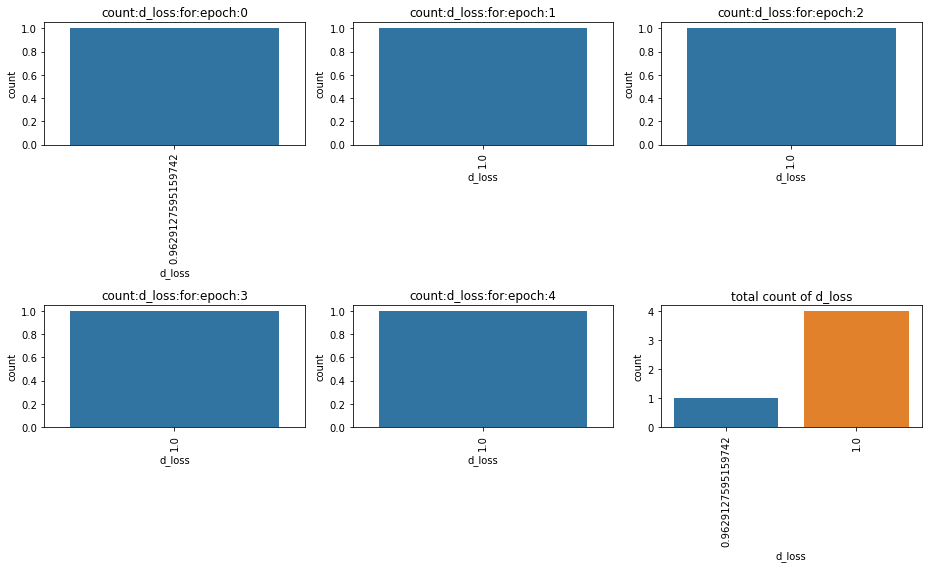

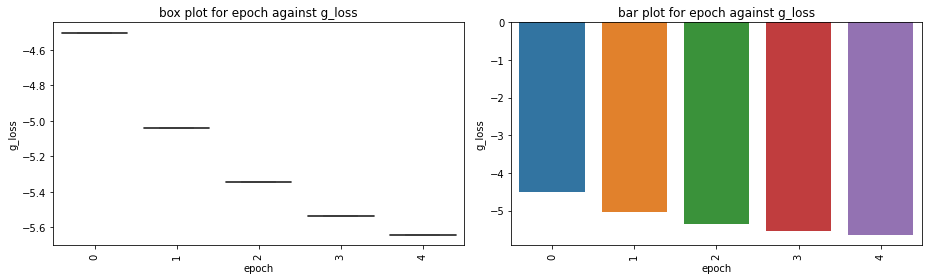

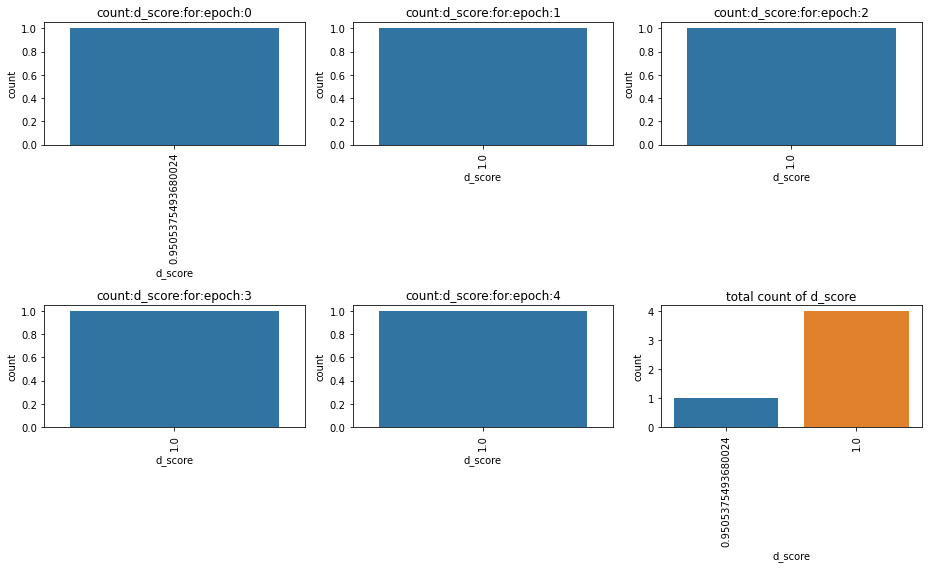

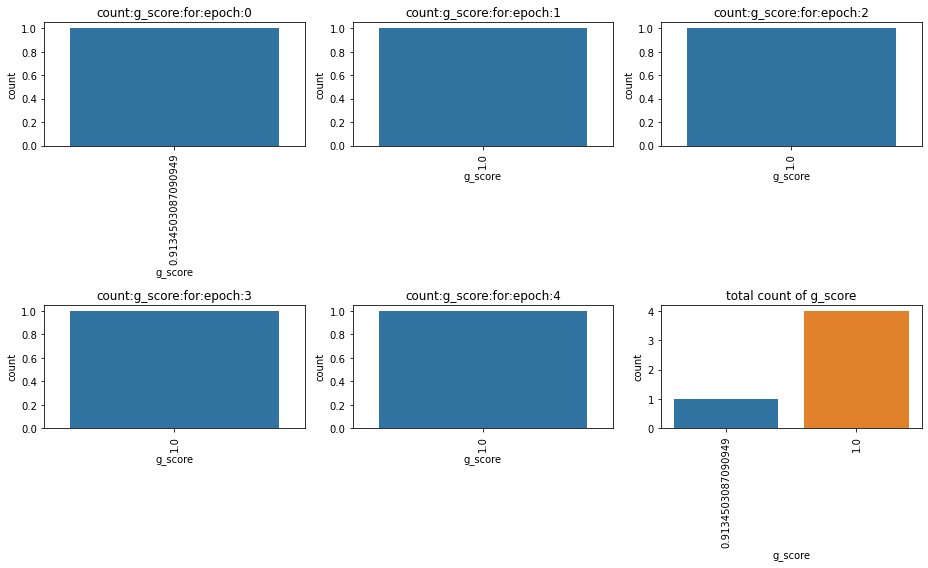

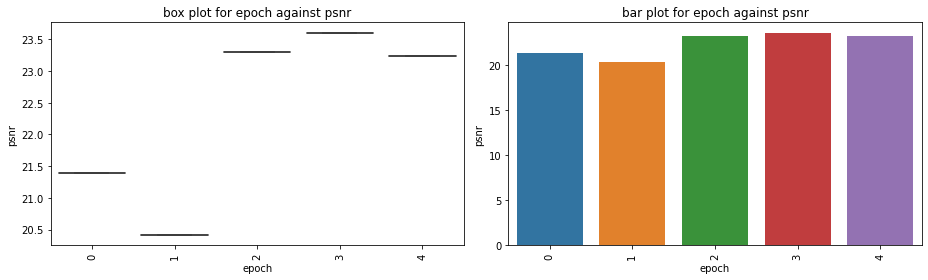

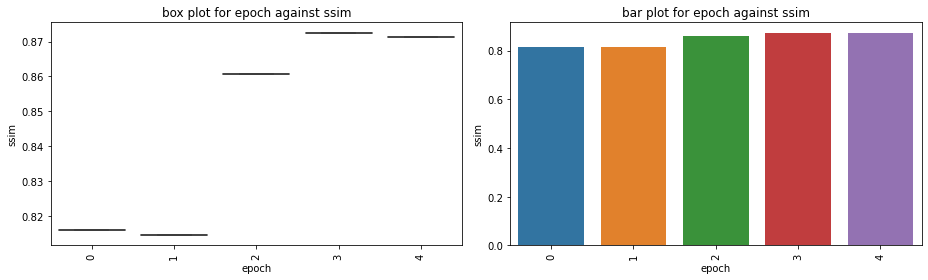

In [29]:
juvini.juvini_against_target(results,target_col='epoch')

Numerical columns: ['d_loss', 'g_loss', 'd_score', 'g_score', 'psnr', 'ssim']
Categorical columns: ['epoch']
Analysis of numeric d_loss and numeric d_loss


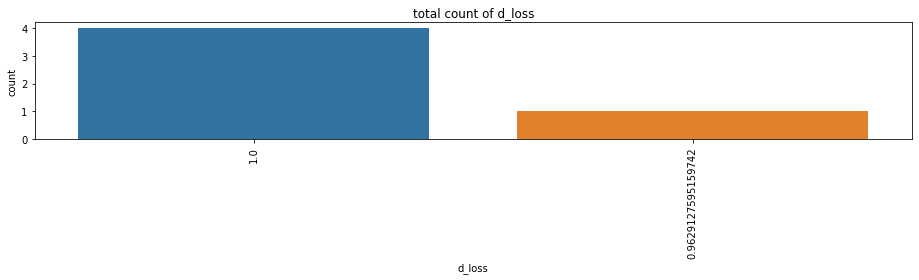

Analysis of numeric d_loss and numeric g_loss


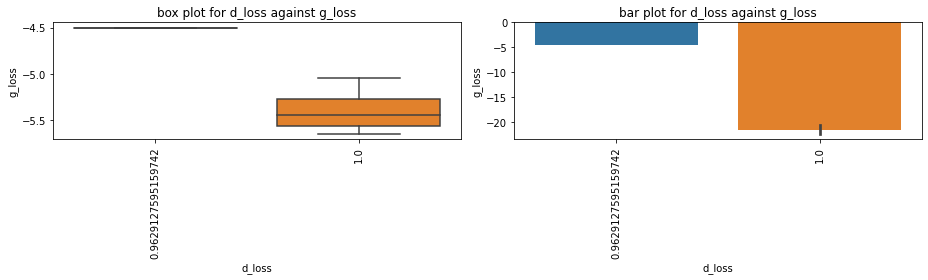

Analysis of numeric d_loss and numeric d_score


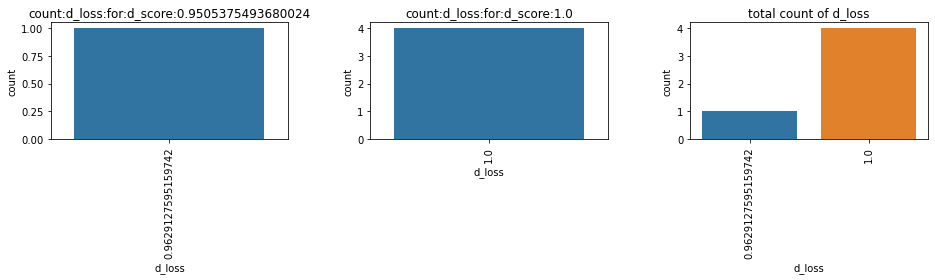

Analysis of numeric d_loss and numeric g_score


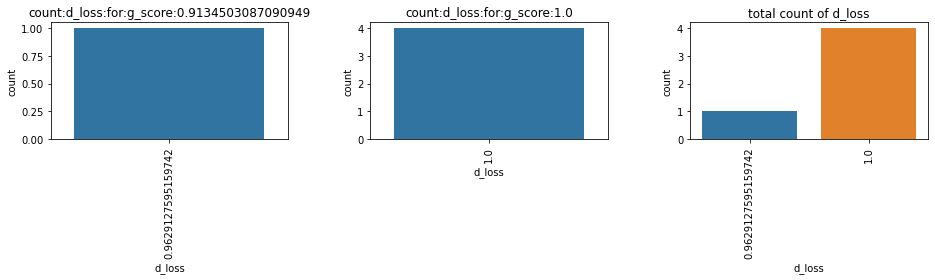

Analysis of numeric d_loss and numeric psnr


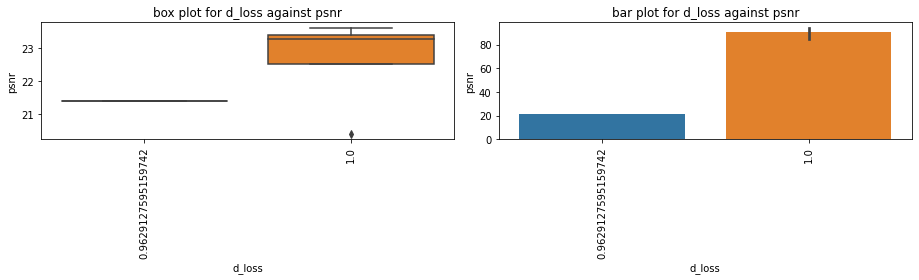

Analysis of numeric d_loss and numeric ssim


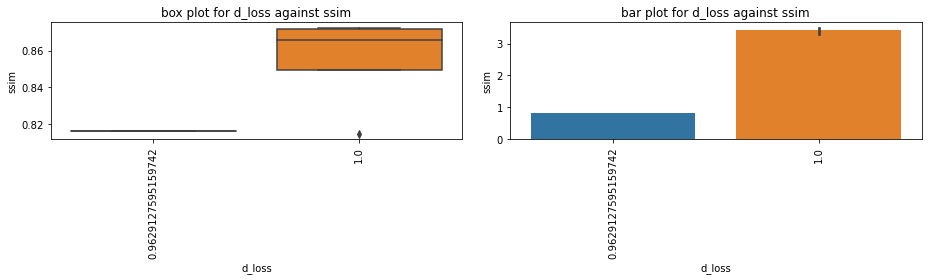

Analysis of numeric g_loss and numeric g_loss


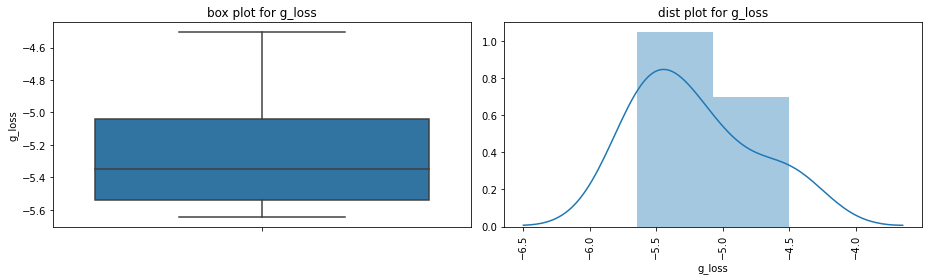

Analysis of numeric g_loss and numeric d_score


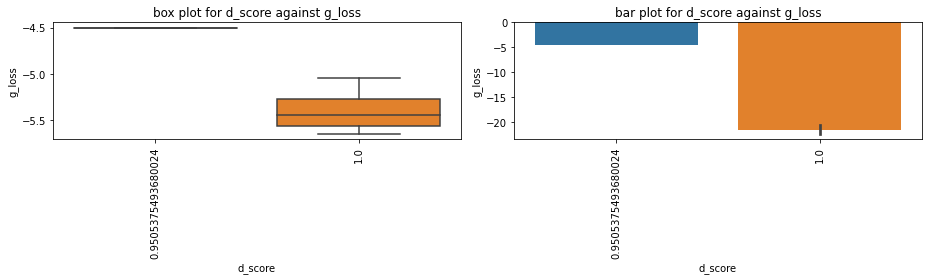

Analysis of numeric g_loss and numeric g_score


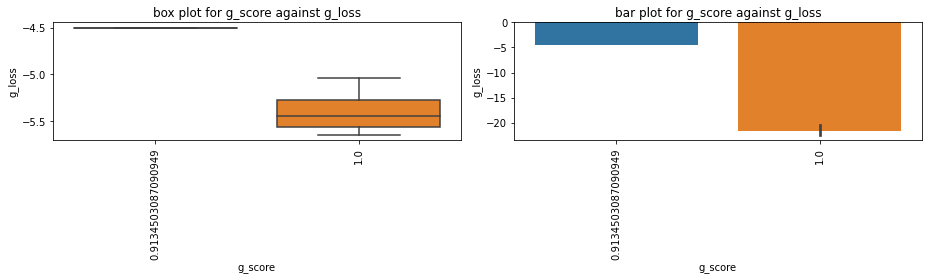

Analysis of numeric g_loss and numeric psnr


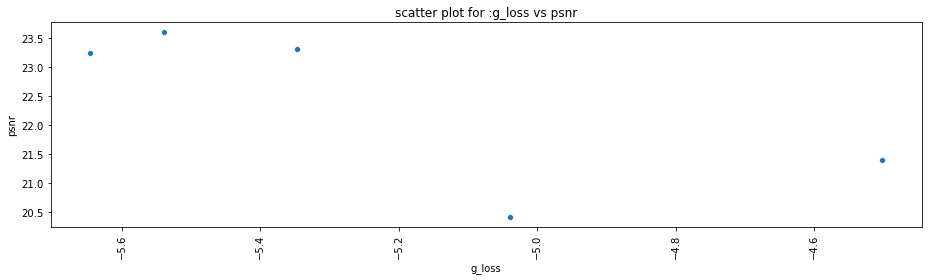

Analysis of numeric g_loss and numeric ssim


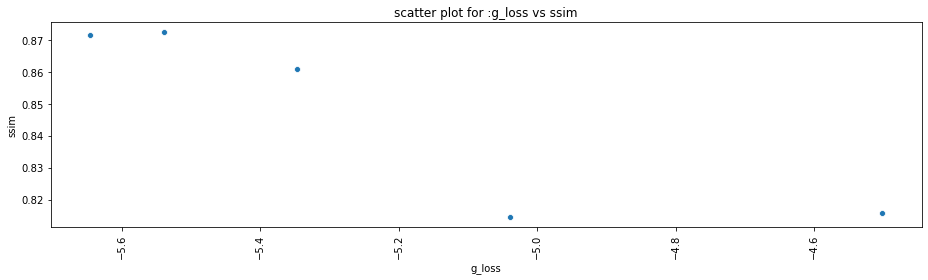

Analysis of numeric d_score and numeric d_score


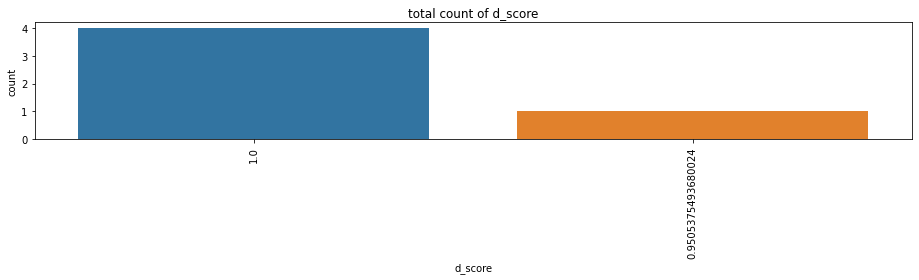

Analysis of numeric d_score and numeric g_score


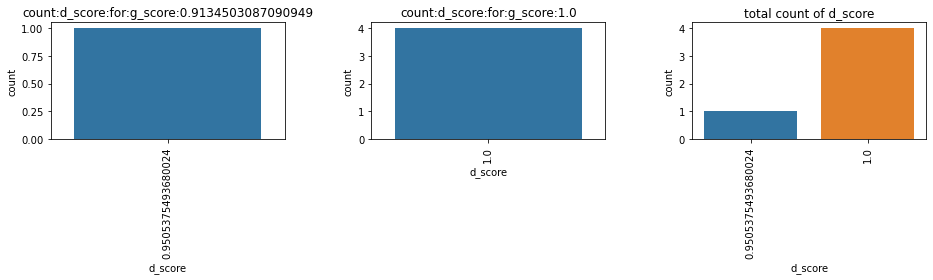

Analysis of numeric d_score and numeric psnr


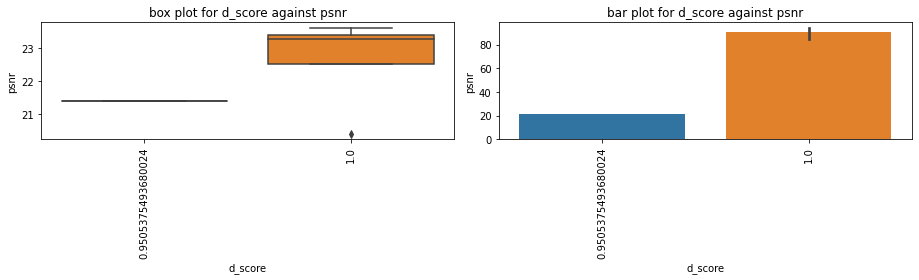

Analysis of numeric d_score and numeric ssim


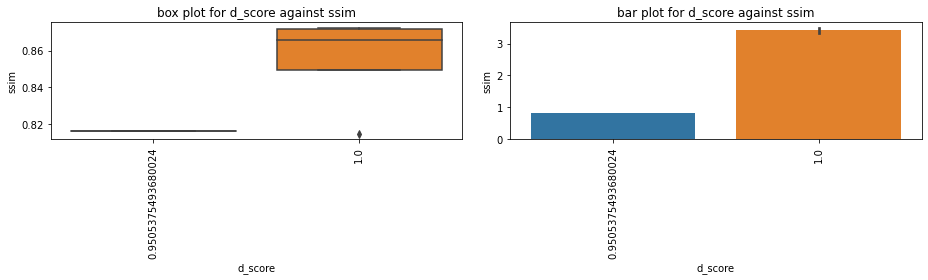

Analysis of numeric g_score and numeric g_score


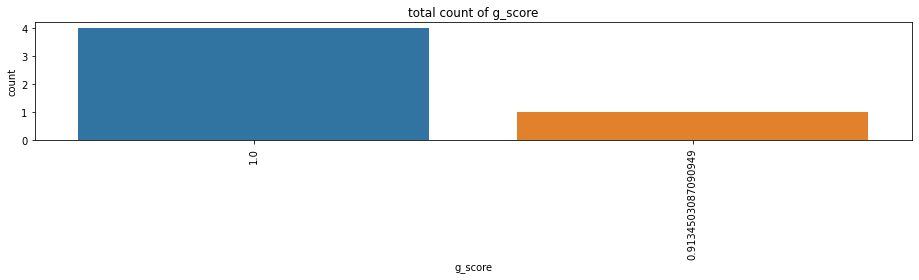

Analysis of numeric g_score and numeric psnr


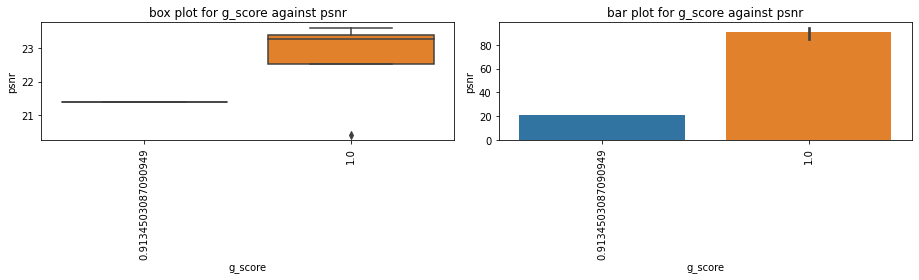

Analysis of numeric g_score and numeric ssim


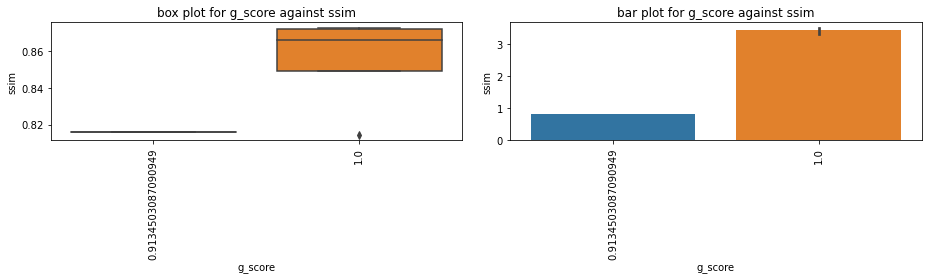

Analysis of numeric psnr and numeric psnr


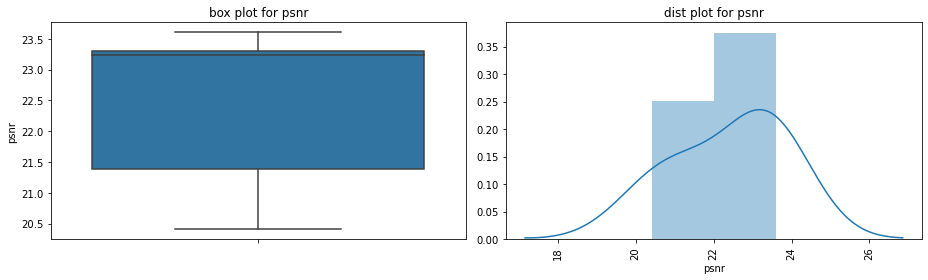

Analysis of numeric psnr and numeric ssim


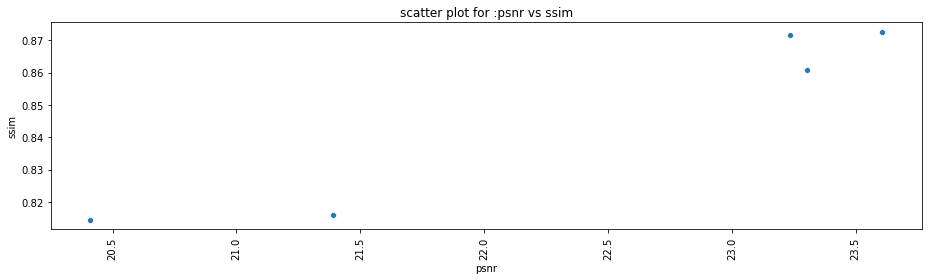

Analysis of numeric ssim and numeric ssim


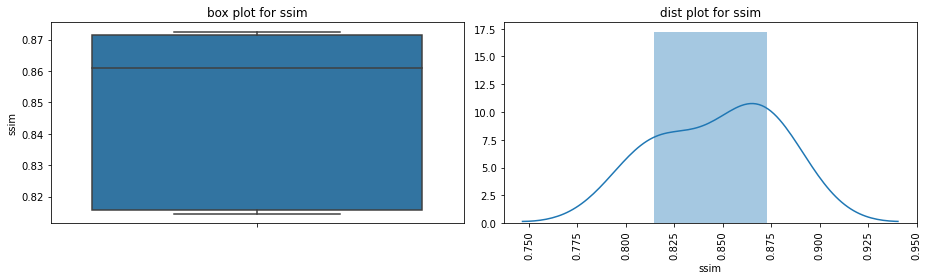

Analysis of categorical epoch and categorical epoch


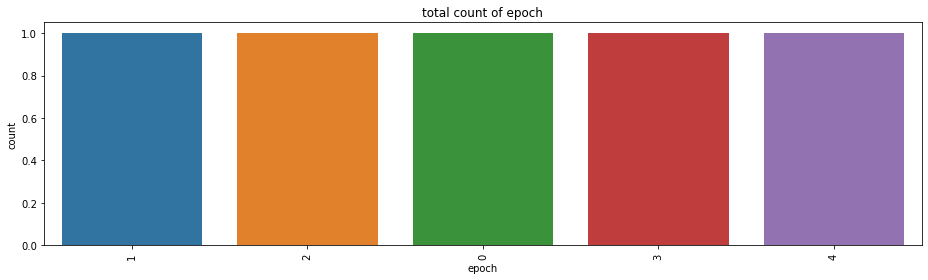

Analysis of categorical d_loss and numerical epoch


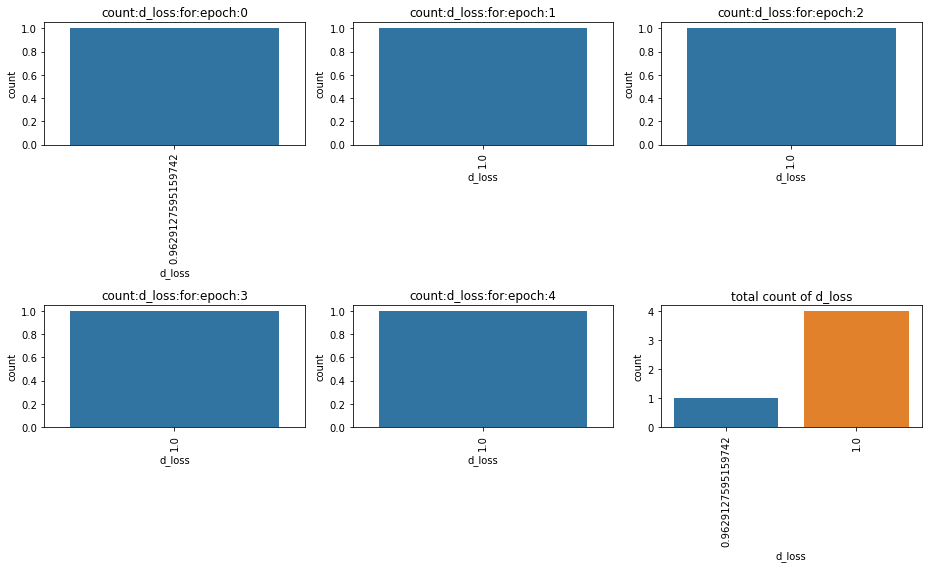

Analysis of categorical g_loss and numerical epoch


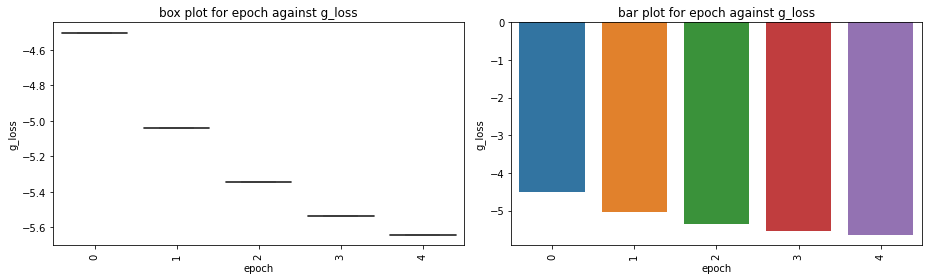

Analysis of categorical d_score and numerical epoch


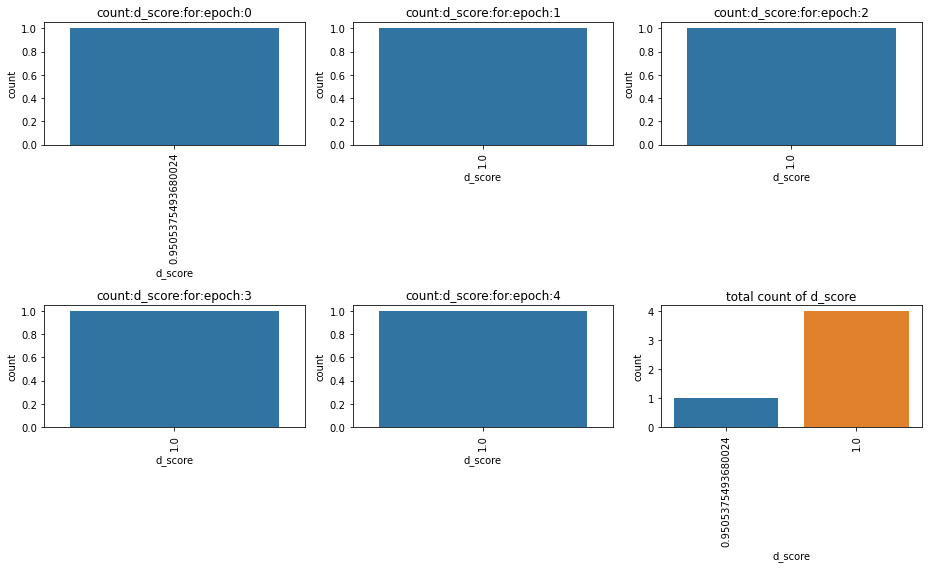

Analysis of categorical g_score and numerical epoch


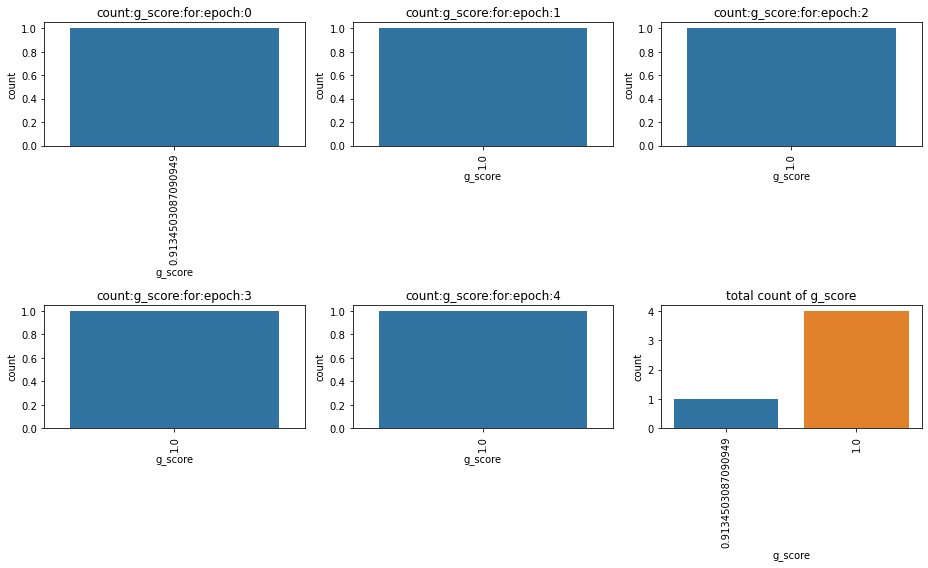

Analysis of categorical psnr and numerical epoch


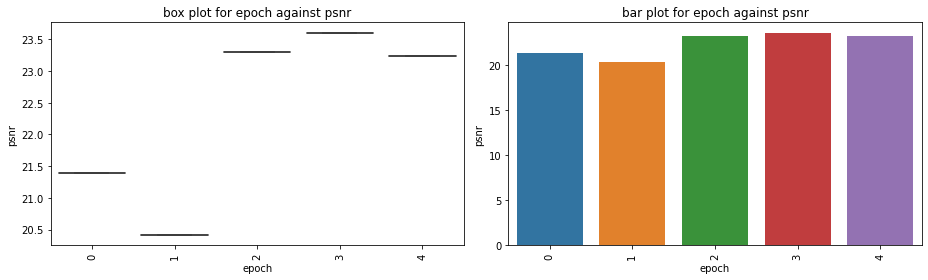

Analysis of categorical ssim and numerical epoch


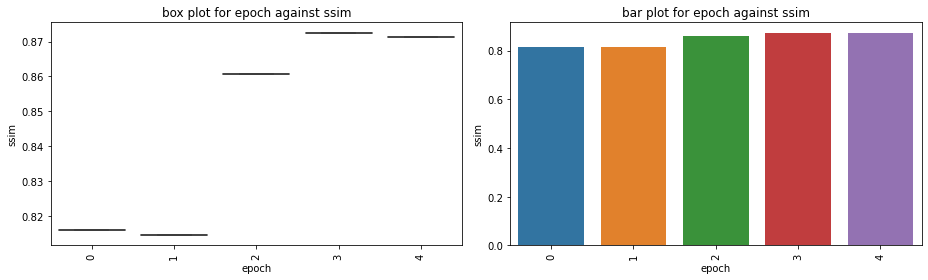

True

In [27]:
juvini.juvini_profile(results)